In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import subprocess, cv2, json, os, sys, shutil, pyk4a, time
import numpy as np, matplotlib.pyplot as plt
from kinectacq.acquisition import start_recording
from kinectacq.paths import DATA_DIR, ensure_dir

### Set up recording location and duration info

In [3]:
import datetime

In [4]:
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
timestamp

'2022-03-03_11-39-50'

In [5]:
filename_prefix = DATA_DIR / 'test_recording' / timestamp
recording_length = 10

In [6]:
ensure_dir(filename_prefix)

In [7]:
filename_prefix

PosixPath('/home/dattalab3/Documents/TimS/kinectacq/data/test_recording/2022-03-03_11-39-50')

### Get camera information

In [8]:
!k4arecorder --list

Index:0	Serial:000237292012	Color:1.6.108	Depth:1.6.79


### Set up devices
- each k4a device needs to be configured
- multi-camera rigs need to set up the WiredSyncMode
    - Master = WiredSyncMode.MASTER
    - Subordinate = WiredSyncMode.SUBORDINATE
    - subordinate_delay_off_master_usec=640 (master samples every 900usec)

In [9]:
from pyk4a import (
    PyK4A,
    Config,
    ColorResolution,
    DepthMode,
    WiredSyncMode,
)

In [10]:
devices = {
    "master": {
        "id": 0,
        "pyk4a_config": {
            "color_resolution": ColorResolution.RES_720P,
            "depth_mode": DepthMode.NFOV_UNBINNED,
            #"synchronized_images_only": False,
            ###"wired_sync_mode": WiredSyncMode.MASTER,
        },
        "process_kwargs": {
            "display_frames": True,
            "display_time": False,
        },
    }
}

### Testing

In [11]:
from multiprocessing import Process, Queue
from kinectacq.acquisition import capture_from_azure 

In [12]:
device_name = "master"

In [13]:
devices[device_name]["id"]

0

In [14]:
devices[device_name]["pyk4a_config"]

{'color_resolution': <ColorResolution.RES_720P: 1>,
 'depth_mode': <DepthMode.NFOV_UNBINNED: 2>}

In [15]:
k4a_obj = PyK4A(
    Config(**devices[device_name]["pyk4a_config"]),
    device_id=devices[device_name]["id"],
)

In [16]:
k4a_obj

In [44]:
k4a_obj.start()

In [123]:
capture = k4a_obj.get_capture()

In [124]:
capture.color.shape, capture.ir.shape, capture.depth.shape

((720, 1280, 4), (576, 640), (576, 640))

In [125]:
capture = k4a_obj.get_capture()
print(capture.color.shape, capture.ir.shape, capture.depth.shape)
print(capture._ir_timestamp_usec)

(720, 1280, 4) (576, 640) (576, 640)
827833555


(array([3.64832e+05, 3.75800e+03, 4.30000e+01, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 7.00000e+00]),
 array([    0. ,  6553.5, 13107. , 19660.5, 26214. , 32767.5, 39321. ,
        45874.5, 52428. , 58981.5, 65535. ]),
 <BarContainer object of 10 artists>)

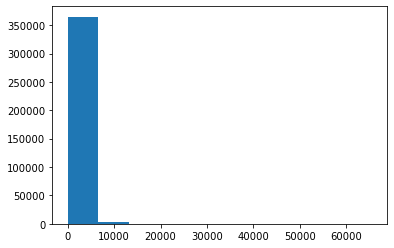

In [126]:
plt.hist(capture.ir.flatten())

In [127]:
ir = capture.ir

In [128]:
ir = ir.astype(np.float32)

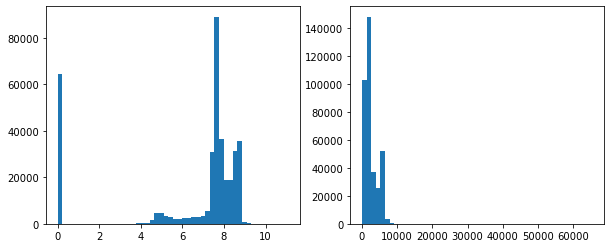

In [129]:
fig, axs = plt.subplots(ncols=2, figsize=(10,4))
axs[0].hist(np.log(1+ir.flatten()), bins=50);
axs[1].hist(ir.flatten(), bins=50);

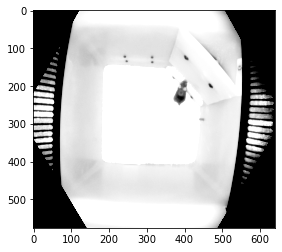

In [130]:
plt.imshow(np.log(1+ir), cmap = 'Greys_r', vmin=6, vmax=8)

In [145]:
ir_depth_xmin = 180
ir_depth_xmax = 260
ir_depth_ymin = 350
ir_depth_ymax = 420

color_xmin = 200
color_xmax = 400
color_ymin = 600
color_ymax = 800

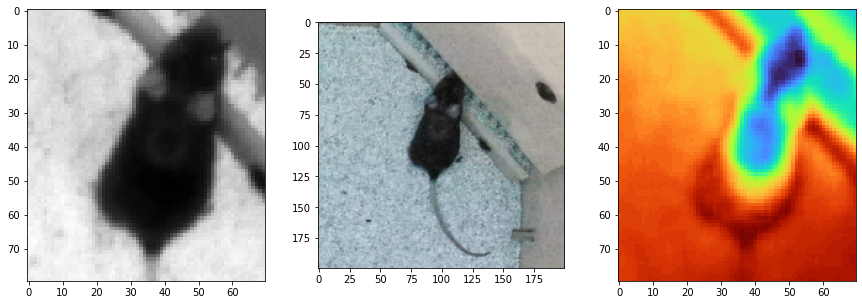

In [158]:
fig, ax = plt.subplots(ncols=3, figsize=(15,5))
ax[0].imshow(ir[ir_depth_xmin:ir_depth_xmax, ir_depth_ymin:ir_depth_ymax], cmap="Greys_r")
ax[1].imshow(color[color_xmin:color_xmax, color_ymin:color_ymax,:3])
ax[2].imshow(depth[ir_depth_xmin:ir_depth_xmax, ir_depth_ymin:ir_depth_ymax], cmap="turbo")


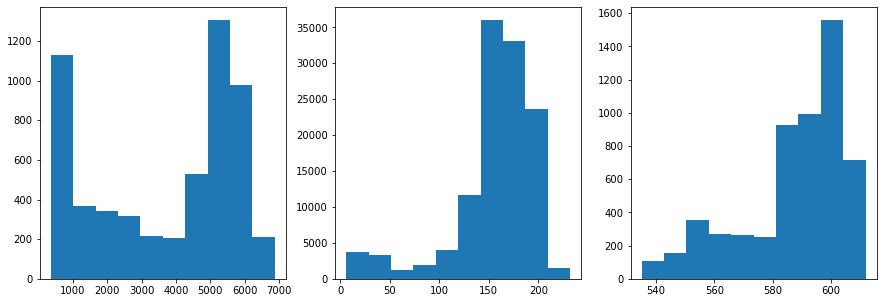

In [160]:
fig, ax = plt.subplots(ncols=3, figsize=(15,5))
ax[0].hist(ir[ir_depth_xmin:ir_depth_xmax, ir_depth_ymin:ir_depth_ymax].flatten());
ax[1].hist(color[color_xmin:color_xmax, color_ymin:color_ymax,:3].flatten());
ax[2].hist(depth[ir_depth_xmin:ir_depth_xmax, ir_depth_ymin:ir_depth_ymax].flatten());


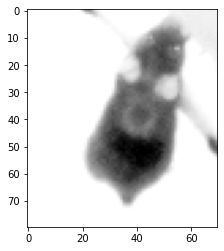

In [131]:
plt.imshow(np.clip(np.log(1+ir[180:260,350:420]), 6, 8), cmap = 'Greys_r', vmin=6, vmax=8)

In [132]:
depth = capture.depth

In [133]:
depth.dtype

dtype('uint16')

In [134]:
depth = depth.astype(np.float32)

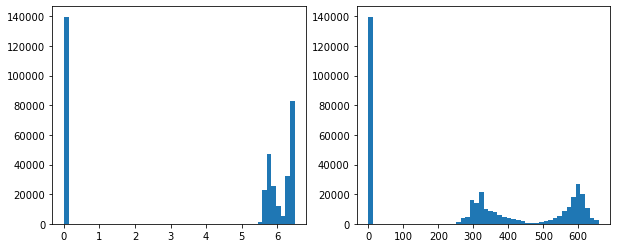

In [135]:
fig, axs = plt.subplots(ncols=2, figsize=(10,4))
axs[0].hist(np.log(1+depth.flatten()), bins=50);
axs[1].hist(depth.flatten(), bins=50);

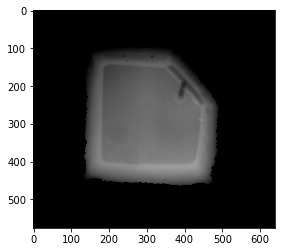

In [136]:
plt.imshow(depth, cmap = 'Greys_r', vmin=500, vmax=800)

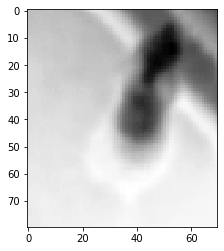

In [137]:
plt.imshow(depth[180:260,350:420], cmap = 'Greys_r', interpolation='None')

In [138]:
color = capture.color

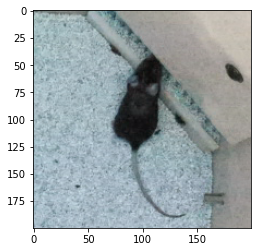

In [142]:
plt.imshow(color[200:400, 600:800,:3])

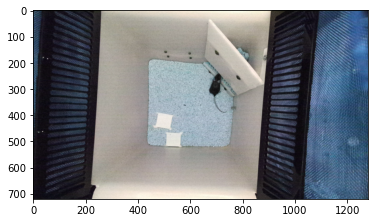

In [140]:
plt.imshow(capture.color[:,:,:3])

In [90]:
capture.color[:,:,:3].shape

(720, 1280, 3)

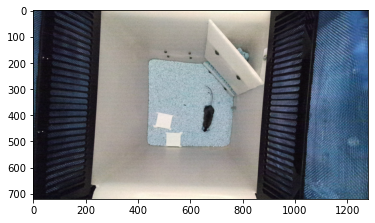

In [91]:
plt.imshow(capture.color)

In [26]:
capture.color.dtype

dtype('uint8')

In [27]:
capture._color_timestamp_usec

1100200

In [28]:
capture._depth_timestamp_usec

1100211

In [29]:
capture._ir_timestamp_usec

1100211

In [31]:
np.shape(capture.ir)

(576, 640)

In [32]:
capture.depth

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

In [33]:
capture.ir

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

/home/dattalab3/miniconda3/envs/k4a/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


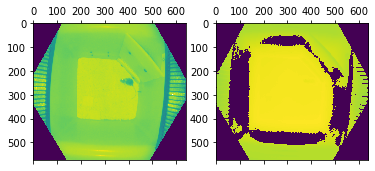

In [34]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.matshow(np.log(capture.ir+1))
ax2.matshow(np.log(capture.depth+1))

(array([136955.,      0.,      0.,   1046.,  60282.,  37933.,  12955.,
          8059.,  46811.,  64599.]),
 array([  0. ,  65.7, 131.4, 197.1, 262.8, 328.5, 394.2, 459.9, 525.6,
        591.3, 657. ]),
 <BarContainer object of 10 artists>)

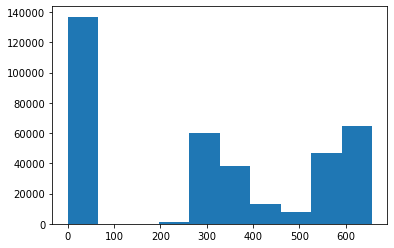

In [35]:
plt.hist(capture.depth.flatten())

In [36]:
depth = capture.depth

In [37]:
depth_pipe = None

In [38]:
from kinectacq.video_io import write_frames  

In [39]:
!ls /home/tim/Projects/azure_acquisition_template/data/test_recording/2022-02-07_14-24-15

ls: cannot access '/home/tim/Projects/azure_acquisition_template/data/test_recording/2022-02-07_14-24-15': No such file or directory


In [40]:
write_frames(
    filename_prefix / "test.depth.avi",
    depth.astype(np.uint8)[None, :, :],
    codec="ffv1",
    close_pipe=False,
    pipe=depth_pipe,
)

In [41]:
k4a_obj.stop()

In [43]:
breakme

NameError: name 'breakme' is not defined

In [42]:
import time
for i in range(10):
    capture = k4a_obj.get_capture()
    print(capture.color.shape, capture.ir.shape, capture.depth.shape)
    print(capture._ir_timestamp_usec*1e-6)
    time.sleep(1)

K4AException: Device is not opened

In [89]:
capture._ir_timestamp_usec*1e-6

311.882755

In [66]:
capture = k4a_obj.get_capture()
print(capture._ir_timestamp_usec)

0


In [105]:
capture = k4a_obj.get_capture()

In [106]:
capture.__dict__

{'_calibration': <pyk4a.calibration.Calibration at 0x7f4ddce48940>,
 '_capture_handle': <capsule object "pyk4a capture handle" at 0x7f4d984e4f30>,
 'thread_safe': True,
 '_color_format': <ImageFormat.COLOR_BGRA32: 3>,
 '_color': None,
 '_color_timestamp_usec': 0,
 '_color_system_timestamp_nsec': 0,
 '_color_exposure_usec': None,
 '_color_white_balance': None,
 '_depth': None,
 '_depth_timestamp_usec': 0,
 '_depth_system_timestamp_nsec': 0,
 '_ir': None,
 '_ir_timestamp_usec': 0,
 '_ir_system_timestamp_nsec': 0,
 '_depth_point_cloud': None,
 '_transformed_depth': None,
 '_transformed_depth_point_cloud': None,
 '_transformed_color': None,
 '_transformed_ir': None}

In [107]:
capture.color.shape#, capture.ir.shape, capture.depth.shape

(720, 1280, 4)

In [124]:
capture._color_timestamp_usec, capture._color_timestamp_usec*1e-6

(703382733, 703.3827329999999)

In [125]:
type(capture._color_timestamp_usec)

int

In [127]:
capture._color_system_timestamp_nsec

172484687609538

In [110]:
capture._color_timestamp_usec.astype('uint64')

AttributeError: 'int' object has no attribute 'astype'

In [30]:
capture.__dict__

{'_calibration': <pyk4a.calibration.Calibration at 0x7f5a5427ba50>,
 '_capture_handle': <capsule object "pyk4a capture handle" at 0x7f59eef177e0>,
 'thread_safe': True,
 '_color_format': <ImageFormat.COLOR_BGRA32: 3>,
 '_color': array([[[ 30,  15,  23, 255],
         [ 28,  13,  21, 255],
         [ 28,  13,  21, 255],
         ...,
         [ 16,   8,  15, 255],
         [ 19,   8,  16, 255],
         [ 20,   9,  17, 255]],
 
        [[ 29,  16,  24, 255],
         [ 27,  14,  22, 255],
         [ 26,  13,  21, 255],
         ...,
         [ 25,  14,  22, 255],
         [ 25,  14,  22, 255],
         [ 24,  13,  21, 255]],
 
        [[ 31,  17,  28, 255],
         [ 30,  16,  27, 255],
         [ 27,  13,  24, 255],
         ...,
         [ 27,  16,  24, 255],
         [ 30,  17,  25, 255],
         [ 28,  15,  23, 255]],
 
        ...,
 
        [[ 29,  13,  20, 255],
         [ 29,  13,  20, 255],
         [ 29,  13,  20, 255],
         ...,
         [ 27,  12,  20, 255],
         [

In [115]:
type(time.time())

float

In [128]:
time.time_ns()

1645203935136079709

In [134]:
capture = k4a_obj.get_capture()

In [133]:
capture.ir

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

In [130]:
capture.ir is None

False

In [ ]:
172484687609538
1645203935136079709